# Project #2: Feature Detection and Matching
# Introduction to Computer Vision

In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

import sys
import skimage #scikit-learn image manipulation #
from skimage import io
from skimage import data
from skimage.feature import peak_local_max
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt #plot utilities #
import matplotlib.patches as patches
import numpy as np #numerical computations #
from mpl_toolkits.mplot3d import Axes3D
import cv2
import scipy
from scipy.misc import imread
from scipy.ndimage import gaussian_filter
import time
import math
%matplotlib inline

# Harris Corner Detection
The following cell is written to detect corners using Harris corner detection algorithm. Given an image, the function detects all possible corners in the image.

In [2]:
def HarrisCorners(img):
# img: an image that are to be performed Harris corners
# alpha: C(H) = det(H)−αtrace(A)2 = λ1λ2−α(λ1+λ2)2; Harris - Stephens
# alpha = any value between 0:04 and 0:06 inclusive

    Ix = gaussian_filter(img, sigma = 1, order = (0,1))
    Iy = gaussian_filter(img, sigma = 1, order = (1,0))

    Ixx = Ix*Ix
    Iyy = Iy*Iy
    Ixy = Ix*Iy

    Ixxc = gaussian_filter(Ixx, sigma = 2)
    Iyyc = gaussian_filter(Iyy, sigma = 2)
    Ixyc = gaussian_filter(Ixy, sigma = 2)

    H = Ixxc*Iyyc - Ixyc**2 - 0.05*(Ixxc+Iyyc)**2

    H = H - H.min()
    H = H/H.max()

    threshold_indices = H < 0.15
    H[threshold_indices] = 0

    c = peak_local_max(H, min_distance = 5, threshold_abs = 0)
    return c,H,Ix,Iy

The following cell represents a function that is designed to describe each corners as some sort of fitness using feature intensity. 

In [3]:
def FitnessArray(H,c):
    ## intensity of each candidate points, we call this fitness of the point
    F = np.zeros(len(c))         # for all images
    for i in range(len(c)):  # for all seatures
        a,b = c[i,:]
        F[i] = H[a,b]       # copy feature value in fitness array
    return F

This function calculates dominant orientation of each features. I did not see exactly the same concept of representing dominant orientation anywhere. But my function works. This function gives resultant orientation of each feature point which is calculated from gradients of x and y direction of the Harris matrix.

In [206]:
def DominantOrientation(Ix,Iy,c):
    I = Iy/Ix
    DO = np.zeros(len(c))
    for i in range(len(c)):
        a,b = c[i,:]
        r = math.atan(I[a,b])
        ornt = (r*180)/np.pi
        DO[i] = ornt
    return DO

This function gives pixel value of a feature. I needed this function in the next function.

In [207]:
def PixelValue(img,point):
    a,b = point
    pxl = img[a,b]
    return pxl

The following function calculates average pixel value of a group of pixels surrounded by corresponding feature.

In [208]:
def AvgPixelValue(img,point):
    a,b = point
    pxl = np.mean(img[a-2:a+3,b-2:b+3])
    return pxl

This function is similar to the function above. The adjustmen here is, I made number of pixels around a feature as a variable. I needed this somewhere.

In [209]:
def AvgPixelValueV(img,point,v):
    a,b = point
    pxl = np.mean(img[a-v:a+v+1,b-v:b+v+1])
    return pxl

The following function takes argumens (an image, a feature, magnitude of feature, dominant orientation) and gives a rectangle.

In [210]:
def Box(img,feature_loc,magnitude,angl):
    a,b = feature_loc[1],feature_loc[0]
    size = magnitude
    rect = patches.Rectangle((a,b),magnitude,magnitude,angle=angl,linewidth=1,edgecolor='r',facecolor='none')
    return rect

This function plots a rectangle in an image.

In [211]:
def BoxPlot(img,c,H,Do1):
    # arguments: img = image; c = feature locations; H = harris corners; Do1 = orientations
    fig,ax = plt.subplots(1)
    ax.imshow(img,cmap='gray')
    for i in range(len(c)):
        aa,bb = c[i]
        r = Box(img,c[i],100*(H[aa,bb]),Do1[i])
        ax.add_patch(r)
        ax.axis('off')

# Descriptor
Here comes the Descriptor function. I did some literature review along with Dr. Hoovers lectures. I found a lot of algorithms for Descriptor. But, I decided to mame my own descriptor. This is not entirely my own idea. I stole some idea from well established algorithms and modified this to make my own descriptor.
Here is how it works:
1. select a feature at random form first image (we require two images, regardless of illumination, orientation, and scale change)
2. match the feature to all the pre-selected features (from Harris) to the other image given which gives some features in second image (taking 20% error)
3. compare all shortlisted features from second image to the first image based on average pixel values from surrounding pixels
4. select the best matching feature from second image which gives a matching feature from different images
The average pixel value around the feature is the fundamental of this descriptor.

Disclaimer: This descriptor does not guarrantee feature matching all the time. In fact, most of the time, my descriptor fails to match if there is scale change.

In [212]:
def Descriptor(ran,Do1,Do2,c1,c2):
    FinalDO1 = []
    FinalDO2 = []
    # r = 21
    ran = ran
    for i in range(len(Do1)):
        if abs(Do2[ran] - Do1[i]) < abs(Do2[ran])/5:
            FinalDO1.append(i) 
            FinalDO2.append(ran)

    L1 = []
    L2 = []
    for i in range(len(FinalDO1)):
        d1 = Do1[FinalDO1[i]]
        d2 = Do2[FinalDO2[i]]

        loc1 = np.where(Do1 == d1)
        loc2 = np.where(Do2 == d2)

        l1 = c1[loc1]
        l2 = c2[loc2]
        l1 = l1[0]
        l2 = l2[0]
        L1.append(l1)
        L2.append(l2)

    L1 = np.array(L1)
    L2 = np.array(L2)

    P1 = []
    P2 = []
    for i in range(len(L1)):
        p1 = AvgPixelValue(img,L1[i,:])
        p2 = AvgPixelValue(img1,L2[i,:])
        P1.append(p1)
        P2.append(p2)

    Pdelta = abs(np.array(P1) - np.array(P2))
    Ploc = np.argmin(Pdelta)
    FeatureImg1 = L1[Ploc]
    FeatureImg2 = L2[Ploc]
    return FeatureImg1,FeatureImg2,L1,L2

Here I find out Harris corners of an image the image

In [226]:
img = io.imread('P2Images\P1Images\Yosemite\Yosemite1.jpg')
img = skimage.color.rgb2gray(img)

img1 = resize(img, (int(img.shape[0]*0.75), int(img.shape[1]*0.75)),
                       anti_aliasing=True)

c,H,Ix,Iy = HarrisCorners(img)

c1,H1,Ix1,Iy1 = HarrisCorners(img)
c2,H2,Ix2,Iy2 = HarrisCorners(img1)

Finding more parameters from the functions above.

In [214]:
Do1 = DominantOrientation(Ix1,Iy1,c1)
Do2 = DominantOrientation(Ix2,Iy2,c2)
F1 = FitnessArray(H1,c1)
F2 = FitnessArray(H2,c2)

ran = 21
FeatureImg1,FeatureImg2,L1,L2 = Descriptor(ran,Do1,Do2,c1,c2)

Plotting primarily selected features (from Harris corners)

Text(0.5, 1.0, 'Harris Corners')

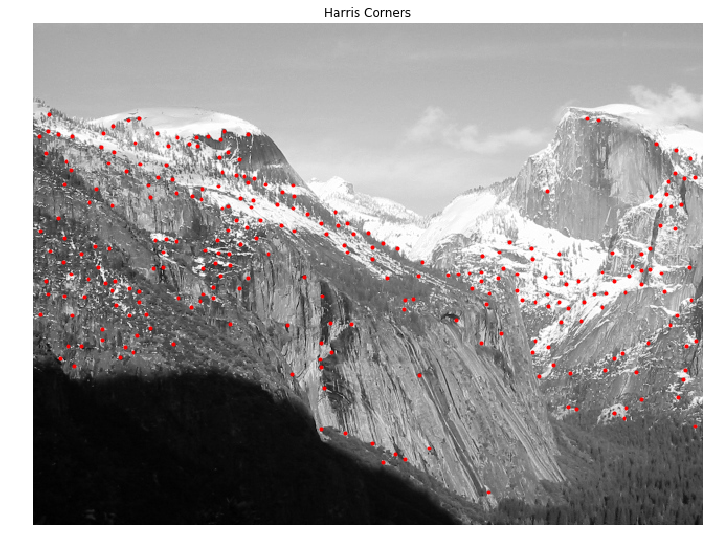

In [227]:
plt.figure(figsize = (12,12))
plt.imshow(img,cmap = plt.cm.gray)
plt.plot(c[:,1],c[:,0],'r.')
plt.axis('off')
plt.title('Harris Corners')

Plotting 2 images of different scale and running Harris corners in each image 

(-0.5, 479.5, 359.5, -0.5)

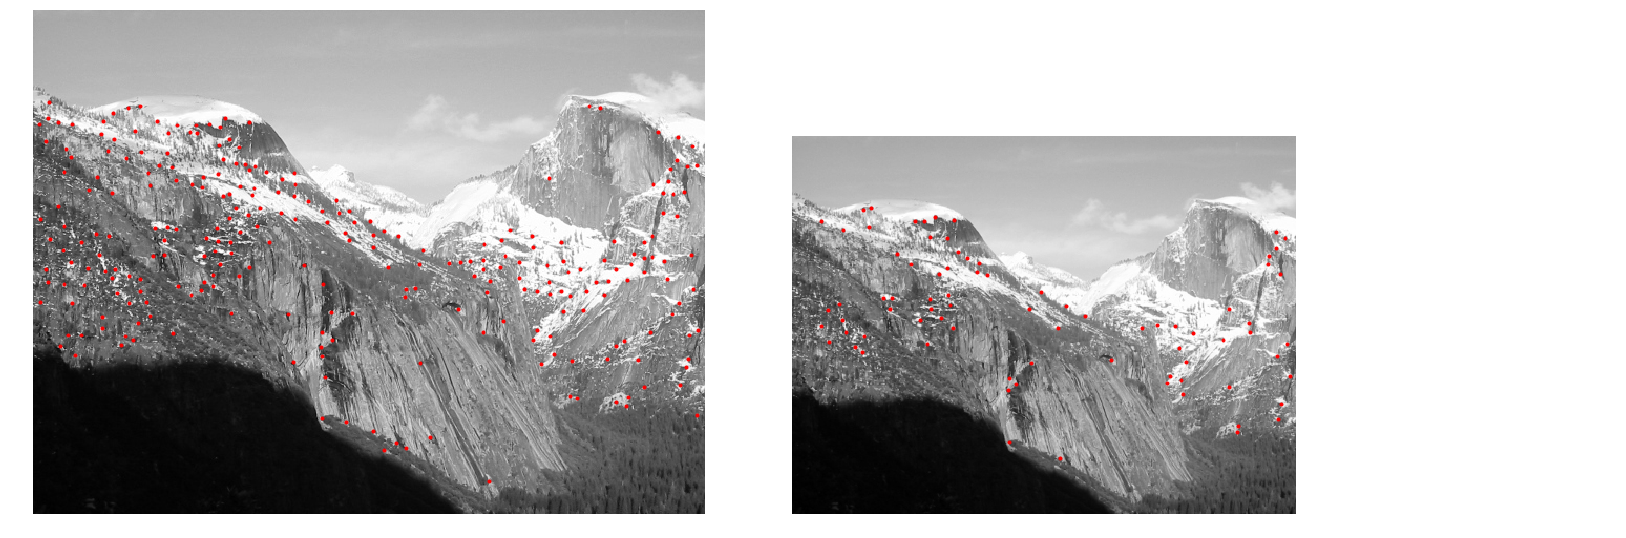

In [228]:
fig, axes = plt.subplots(1,2,figsize=(15, 7),sharex=True, sharey=True)
for ax in axes:
    ax.axis('off')
    
(ax0,ax1) = axes

ax0 = fig.add_axes((-0.75,0,1,1))
ax0.imshow(img,cmap='gray')
ax0.plot(c1[:,1],c1[:,0],'r.')
ax1 = fig.add_axes((0,0,0.75,0.75))
ax1.imshow(img1,cmap='gray')
ax1.plot(c2[:,1],c2[:,0],'r.')

ax0.axis('off')
ax1.axis('off')

Selecting a random feature from right side image and found possible same features in the left side image

(-0.5, 479.5, 359.5, -0.5)

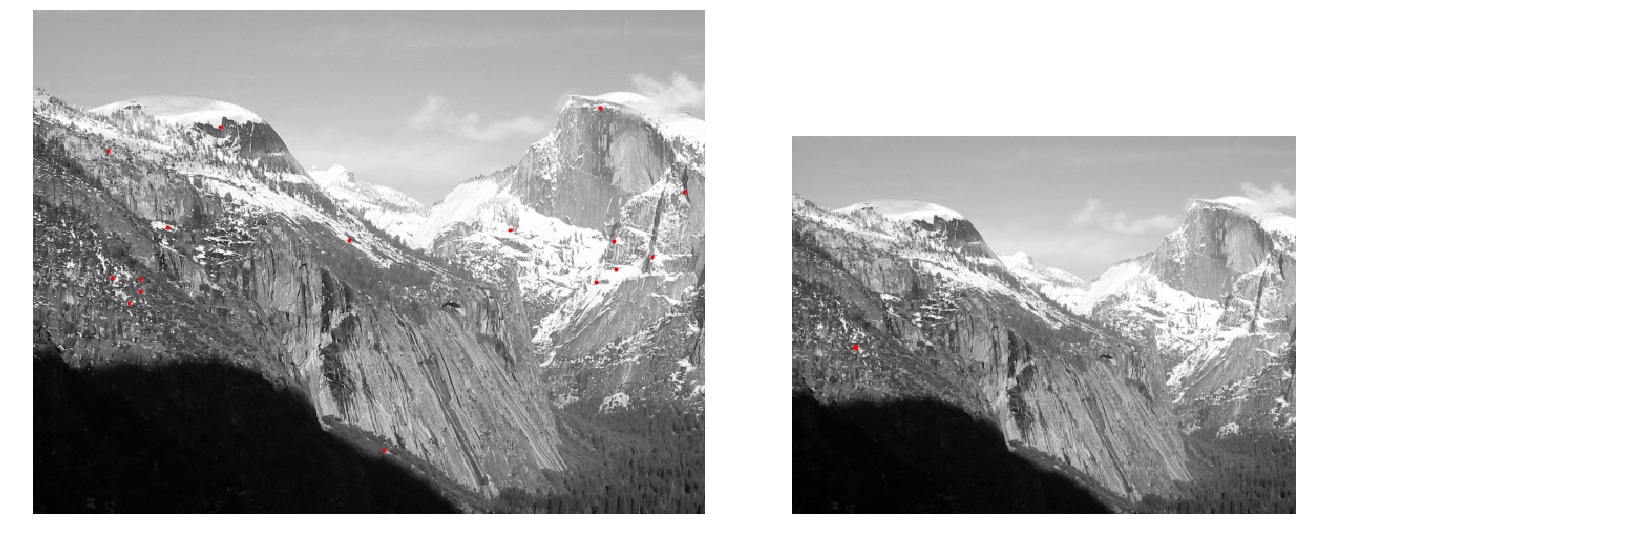

In [229]:
fig, axes = plt.subplots(1,2,figsize=(15, 7),sharex=True, sharey=True)
for ax in axes:
    ax.axis('off')
    
(ax0,ax1) = axes

ax0 = fig.add_axes((-0.75,0,1,1))
ax0.imshow(img,cmap='gray')
ax0.plot(L1[:,1],L1[:,0],'r.')
ax1 = fig.add_axes((0,0,0.75,0.75))
ax1.imshow(img1,cmap='gray')
ax1.plot(L2[:,1],L2[:,0],'r.')

ax0.axis('off')
ax1.axis('off')

Using descriptor function, selected best matching feature in the left side image corresponding to right side image

(-0.5, 479.5, 359.5, -0.5)

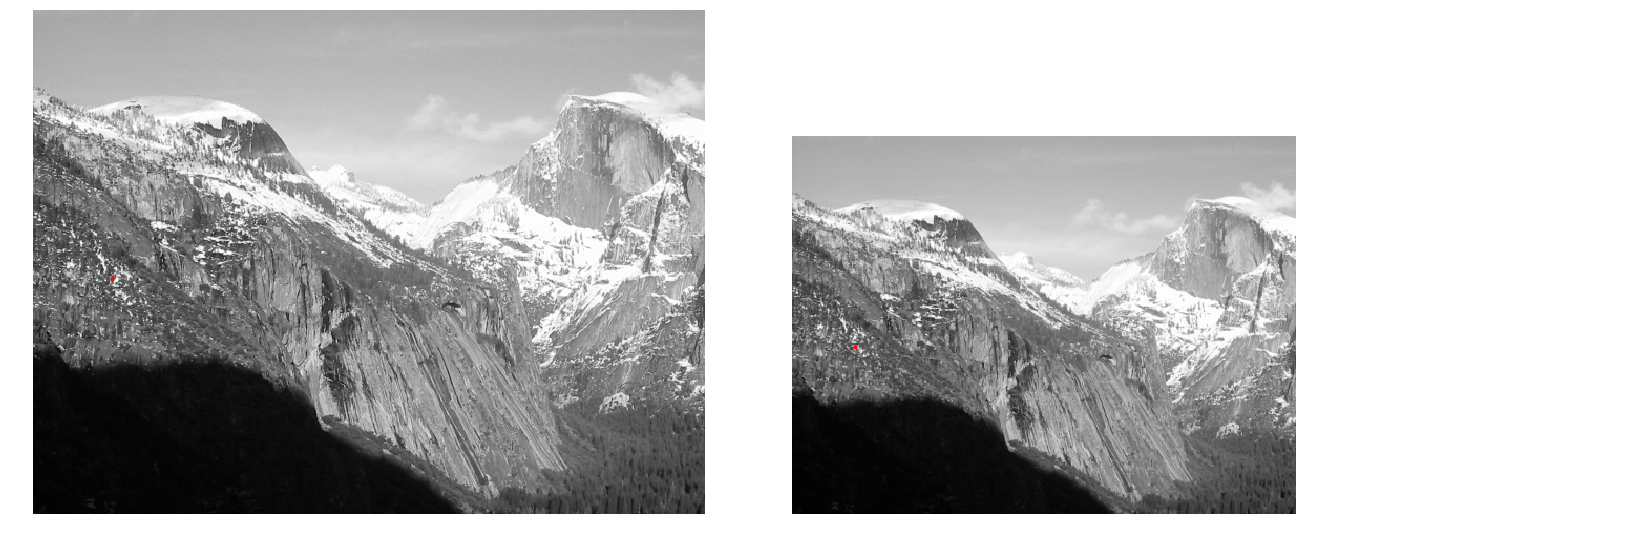

In [230]:
fig, axes = plt.subplots(1,2,figsize=(15, 7),sharex=True, sharey=True)
for ax in axes:
    ax.axis('off')
    
(ax0,ax1) = axes

ax0 = fig.add_axes((-0.75,0,1,1))
ax0.imshow(img,cmap='gray')
ax0.plot(FeatureImg1[1],FeatureImg1[0],'r.')
ax1 = fig.add_axes((0,0,0.75,0.75))
ax1.imshow(img1,cmap='gray')
ax1.plot(FeatureImg2[1],FeatureImg2[0],'r.')

ax0.axis('off')
ax1.axis('off')

The previous plot in a rectangle

(-0.5, 479.5, 359.5, -0.5)

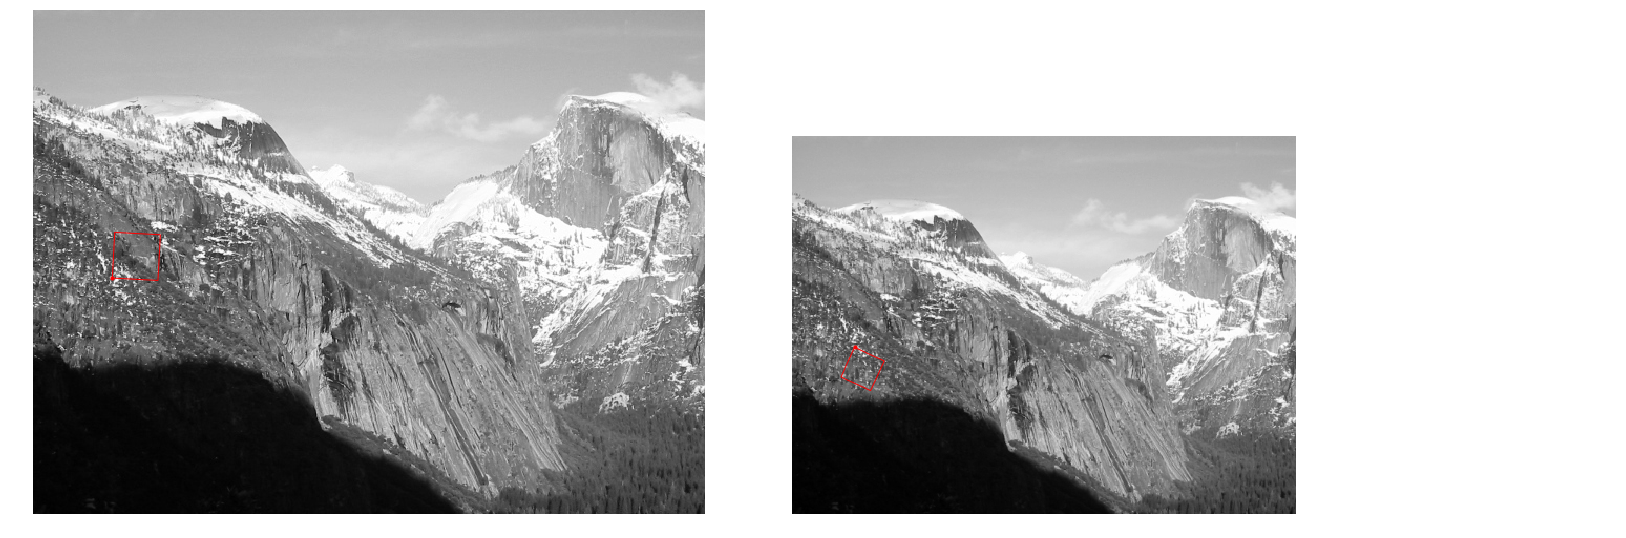

In [231]:
aa1,bb1 = FeatureImg1
aa2,bb2 = FeatureImg2

r1 = Box(img,FeatureImg1,100*(H1[aa1,bb1]),Do1[ran])
r2 = Box(img1,FeatureImg2,100*(H2[aa2,bb2]),Do2[ran])

fig, axes = plt.subplots(1,2,figsize=(15, 7),sharex=True, sharey=True)
for ax in axes:
    ax.axis('off')
    
(ax0,ax1) = axes

ax0 = fig.add_axes((-0.75,0,1,1))
ax0.imshow(img,cmap='gray')
ax0.plot(FeatureImg1[1],FeatureImg1[0],'r.')
ax0.add_patch(r1)
ax1 = fig.add_axes((0,0,0.75,0.75))
ax1.imshow(img1,cmap='gray')
ax1.plot(FeatureImg2[1],FeatureImg2[0],'r.')
ax1.add_patch(r2)

ax0.axis('off')
ax1.axis('off')

All features in rectangles. Depending on the magnitude and orientation of the feature, the rectangle size and orientation changes which is visualized in the following figure.

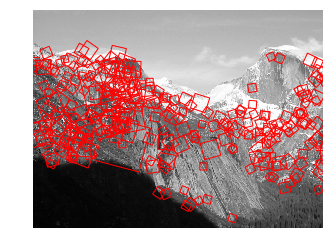

In [232]:
BoxPlot(img,c,H,Do1)

Tried to find out scale of the image based on Harris approach.

In [222]:
a1,b1 = FeatureImg1
a2,b2 = FeatureImg2

img[b1,a1]
img1[b2,a2]

V = []
I1 = []
I2 = []
for v in range(10):
    Px1 = AvgPixelValueV(img,FeatureImg1,v)
    Px2 = AvgPixelValueV(img1,FeatureImg2,v)
    V.append(v)
    I1.append(Px1)
    I2.append(Px2)

For next two figures, I was expecting a convex or a concave figure to make decision and to calculate the exact scale of the images. Unfortunately, it did not work. The algorithm says, it might not converge always. So, could not find out exact scale of the given two images.

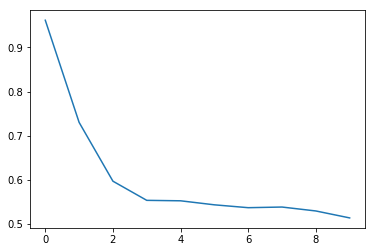

In [223]:
plt.plot(V,I1)

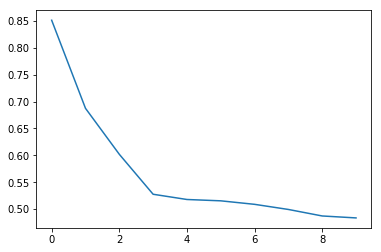

In [224]:
plt.plot(V,I2)

# Ratio test
The best feature over second best feature. Taken absolute difference between values taken from the descriptor and called it fitness of the feature. In ideal case, the ratio should be 1. In, my case, the ratio I got is 0.45 which is not good at all. So, my descriptor is not that effective.

In [225]:
FeatureImg1,FeatureImg2,L1,L2 = Descriptor(ran,Do1,Do2,c1,c2)
FeatureImg11,FeatureImg22,L11,L22 = Descriptor(27,Do1,Do2,c1,c2)

fitness_best = abs(AvgPixelValue(img,FeatureImg1) - AvgPixelValue(img1,FeatureImg2))
fitness_best2 = abs(AvgPixelValue(img,FeatureImg11) - AvgPixelValue(img1,FeatureImg22))
# print(fitness_best,fitness_best2)
Ratio = fitness_best/fitness_best2
print(Ratio)

0.45287144580648775
